# Finding Highlights in a Bundesliga Game

This notebook will create a model to identify when signficant moements happen in a Bundesliga game. It will categorize these events into one of three types: 
- Throw-In
- Challenge
- Play

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio 
import cv2
import os

from fastai.data.all import *
from fastai.vision.all import *

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from IPython.display import Video
from tqdm.notebook import tqdm

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
data_path = Path('data/')
train_path = data_path/'train'
train_df = pd.read_csv(data_path/'train.csv')
train_df.head()

,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,NaN
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,NaN
3,1606b0e6_0,210.124111,start,NaN
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']


In [4]:
df_throwin = train_df[train_df['event'] == 'throwin'].copy()
df_challenge = train_df[train_df['event'] == 'challenge'].copy()
df_play = train_df[train_df['event'] == 'play'].copy()

In [5]:
def vis_event(row, before=5, after=5):
    print(row["event_attributes"])
    filename = f"train_{row.name}.mp4"
    ffmpeg_extract_subclip(
        f'data/train/{row["video_id"]}.mp4',
        #f"../input/dfl-bundesliga-data-shootout/train/{row['video_id']}.mp4", 
        row['time'] - before, 
        row['time'] + after, 
        targetname=filename
    )
    
    return Video(filename, width=800)

In [6]:
vis_event(df_throwin.iloc[0],5,5)

['pass']
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [7]:
vis_event(df_challenge.iloc[0],5,5)

['ball_action_forced']
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [8]:
vis_event(df_play.iloc[0],5,5)

['pass', 'openplay']
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


In [9]:
fps = 25
def get_images(vid_id, time, ind, time_diff, type, replace=False):
    t1 = time - time_diff
    t2 = time + time_diff
    frame_start = int(t1 * fps)
    frame_end = int(t2 * fps)

    video_file = data_path/'train'/vid_id
    p = data_path/'train'/type/str(ind)
    if not os.path.exists(p):
        os.makedirs(p)
    
    for j in range(frame_start, frame_end + 1):
        p_old = data_path/vid_id/f'{ind}/{j}.png'
        if os.path.exists(p_old):
            os.rename(p_old, p/f'{vid_id}-{j}.png')
        
        if not os.path.exists(p/f'{vid_id}-{j}.png') or replace == True:
            try:
                image = iio.imread(f'{video_file}.mp4', index=j)
                iio.imwrite(p/f'{vid_id}-{j}.png', image)
            except IndexError:
                print(j, p)
                p = None
    return p

In [10]:
fnames = [get_images(v, t, i, 0.15, 'throwin') for v, t, i in tqdm(zip(df_throwin['video_id'], df_throwin['time'], df_throwin.index.values), total=len(df_throwin))]
df_throwin['fnames'] = fnames
fnames[0:3]

  0%|          | 0/172 [00:00<?, ?it/s]

[Path('data/train/throwin/7'),
 Path('data/train/throwin/101'),
 Path('data/train/throwin/119')]

In [11]:
fnames = [get_images(v, t, i, 0.15, 'challenge') for v, t, i in tqdm(zip(df_challenge['video_id'], df_challenge['time'], df_challenge.index.values), total=len(df_challenge))]
df_challenge['fnames'] = fnames
fnames[0:3]

  0%|          | 0/624 [00:00<?, ?it/s]

[Path('data/train/challenge/1'),
 Path('data/train/challenge/4'),
 Path('data/train/challenge/59')]

In [12]:
# creating positive set
scale = 3
df_pos = df_play[df_play.event_attributes.str.contains('cross') | df_play.event_attributes.str.contains('corner') | df_play.event_attributes.str.contains('freekick')]
print(df_pos.shape)
df_pos = pd.concat([df_pos, df_play[df_play['event_attributes'] == "['pass', 'openplay']"].sample(n=len(df_pos)*scale,replace=False, random_state=42)], axis=0)
df_pos

(249, 4)


,video_id,time,event,event_attributes
43,1606b0e6_0,272.110,play,"['cross', 'openplay']"
66,1606b0e6_0,313.230,play,"['cross', 'openplay']"
73,1606b0e6_0,356.230,play,"['pass', 'freekick']"
76,1606b0e6_0,361.390,play,"['cross', 'openplay']"
153,1606b0e6_0,556.710,play,"['cross', 'openplay']"
...,...,...,...,...
3513,35bd9041_1,1157.157,play,"['pass', 'openplay']"
2193,1606b0e6_1,3272.790,play,"['pass', 'openplay']"
11154,ecf251d4_0,2946.827,play,"['pass', 'openplay']"
2207,1606b0e6_1,3297.950,play,"['pass', 'openplay']"


In [13]:
fnames = [get_images(v, t, i, 0.15, 'play') for v, t, i in tqdm(zip(df_pos['video_id'], df_pos['time'], df_pos.index.values), total=len(df_pos))]
df_pos['fnames'] = fnames
print(len(fnames))
fnames[0:3]

  0%|          | 0/996 [00:00<?, ?it/s]

996


[Path('data/train/play/43'),
 Path('data/train/play/66'),
 Path('data/train/play/73')]

## Creating the DataLoader to Make Binary Classifier for each type of highlight

In [14]:
# TODO: Create neg_paths
# TODO: Create Labeller for throw-in, challenge, play
# TODO: Create Learner for throw-in, challenge, play
# TODO: Propagate learners on test clips 


In [15]:
def get_frames(vid_id, time, time_diff=0.15):
    t1 = time - time_diff
    t2 = time + time_diff
    frame_start = int(t1 * fps)
    frame_end = int(t2 * fps)
    for i in range(frame_start, frame_end + 1):
        yield (vid_id, i)

In [16]:
throwin_path = data_path/'train'/'throwin'
throwin_frames = [get_frames(v, t) for v, t in zip(df_throwin.video_id, df_throwin.time)]
len(throwin_frames)

172

In [17]:
challenge_path = data_path/'train'/'challenge'
challenge_frames = [get_frames(v, t) for v, t in zip(df_challenge.video_id, df_challenge.time)]
len(challenge_frames)

624

In [18]:
play_path = data_path/'train'/'play'
play_frames = [get_frames(v, t) for v, t in zip(df_play.video_id, df_play.time)]
len(play_frames)


3586

In [19]:
# Non-Highlights Sequences
import av

def extract_frames(video_path):
    '''convert video to PIL images'''
    video = av.open(str(video_path), fps=25)
    for frame in video.decode(video=0):
        yield frame.to_image()

def avi2frames(video_path, force=False):
    "Extract frames from avi file to jpgs"
    dest_path = train_path/'neg_paths'/video_path.stem
    if not os.path.exists(dest_path):
        try:
            os.mkdir(dest_path)
        except FileNotFoundError:
            os.mkdir(dest_path.parent)
            os.mkdir(dest_path)
    print(dest_path)
    video = av.open(str(video_path))
    count = 0
    save_frame = False
    for frame in video.decode(video=0):
        if save_frame:
            fname = dest_path/str(f'{video_path.stem}-{frame.index}.png')
            key = (video_path.stem, frame.index)
            if key in challenge_frames or key in play_frames or key in throwin_frames:
                print(f'Skipping: {key}')
                save_frame = False
            elif not os.path.exists(fname):
                frame.to_image().save(str(fname))
            count += 1
            if count % 8 == 0:
                save_frame = False
        else:
            if random.random() <= 0.05:
                save_frame = True
        if count >= 100 * 8:
            break

In [20]:
video_paths = []
for a in train_path.ls():
    if '.mp4' in str(a):
        video_paths.append(a)
v = video_paths[:3]
v

[Path('data/train/1606b0e6_0.mp4'),
 Path('data/train/1606b0e6_1.mp4'),
 Path('data/train/35bd9041_0.mp4')]

In [32]:
#parallel(avi2frames, video_paths[6:])

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck
data\train\neg_paths\407c5a9e_1
data\train\neg_paths\4ffd5986_0
data\train\neg_paths\9a97dae4_1
data\train\neg_paths\cfbe2e94_0
data\train\neg_paths\cfbe2e94_1
data\train\neg_paths\ecf251d4_0


(#6) [None,None,None,None,None,None]

## Creating and Training the Model

In [21]:
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    try:
        return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))
    except ValueError:
        return self.ls().sorted(key=lambda f: int(f.with_suffix('').name.split('-')[1]))

In [22]:
def throwin_labeller(path):
    return 'throwin' in str(path)

def challenge_labeller(path):
    return 'challenge' in str(path)

def play_labeller(path):
    return 'play' in str(path)

def labeller(path):
    p = str(path)
    if 'throwin' in p:
        return 'throwin'
    elif 'challenge' in p:
        return 'challenge'
    elif 'play' in p:
        return 'play'
    else:
        return 'none'

In [23]:
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs): 
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

In [24]:
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, seq_len=20):
        store_attr()
        
    def encodes(self, path: Path):
        "Get a list of images files for folder path"
        frames = path.ls_sorted()
        n_frames = len(frames)
        s = slice(0, min(self.seq_len, n_frames))
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [25]:
def get_throwin_dataloaders(files, bs=8, image_size=64, seq_len=8, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [throwin_labeller]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

def get_challenge_dataloaders(files, bs=8, image_size=64, seq_len=8, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [challenge_labeller]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

def get_play_dataloaders(files, bs=8, image_size=64, seq_len=8, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [play_labeller]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

def get_action_dataloaders(files, bs=8, image_size=64, seq_len=8, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [labeller, Categorize]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor], 
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

In [26]:
throwin_paths = Path(train_path/'throwin').ls()
challenge_paths = Path(train_path/'challenge').ls()
play_paths = Path(train_path/'play').ls()

In [25]:
neg_paths = Path(train_path/'neg_paths').ls()
for path in tqdm(neg_paths):
    count = 0
    tmp = path.ls_sorted()
    for p in tmp:
        if '.' in str(p):
            try:
                os.rename(p, path/f'{count}/{p.stem}.png')
            except FileNotFoundError:
                os.mkdir(path/f'{count}')
                os.rename(p, path/f'{count}/{p.stem}.png')
        try:
            if len(Path(path/f'{count}').ls()) == 8:
                count += 1
        except FileNotFoundError:
            print(p)
            break


  0%|          | 0/12 [00:00<?, ?it/s]

In [27]:
neg_paths = []
for path in Path(train_path/'neg_paths').ls():
    for p in path.ls():
        neg_paths.append(p)
len(neg_paths)

8927

In [28]:
# Adding negative sequences and creating dataloader
instance_paths = throwin_paths + random.sample(challenge_paths, k=len(throwin_paths))
instance_paths += random.sample(play_paths, k=len(throwin_paths))
instance_paths += random.sample(neg_paths, k=len(throwin_paths))
instance_paths

(#688) [Path('data/train/throwin/101'),Path('data/train/throwin/10227'),Path('data/train/throwin/10236'),Path('data/train/throwin/10246'),Path('data/train/throwin/10272'),Path('data/train/throwin/10328'),Path('data/train/throwin/10360'),Path('data/train/throwin/10372'),Path('data/train/throwin/10477'),Path('data/train/throwin/10519')...]

In [40]:
tfm = ImageTupleTfm()
tfm(instance_paths[0])

(PILImage mode=RGB size=1920x1080,
 PILImage mode=RGB size=1920x1080,
 PILImage mode=RGB size=1920x1080,
 PILImage mode=RGB size=1920x1080,
 PILImage mode=RGB size=1920x1080,
 PILImage mode=RGB size=1920x1080,
 PILImage mode=RGB size=1920x1080,
 PILImage mode=RGB size=1920x1080)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


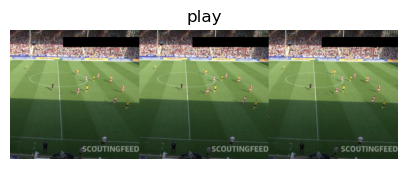

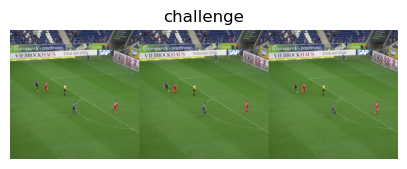

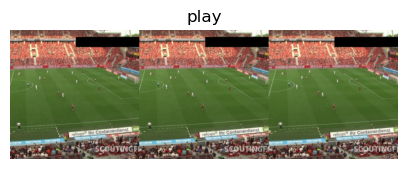

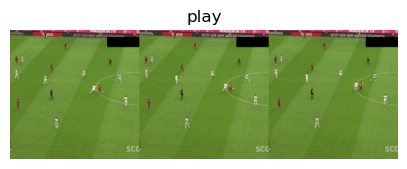

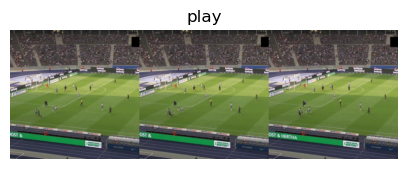

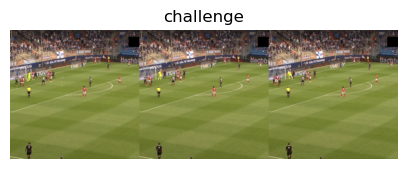

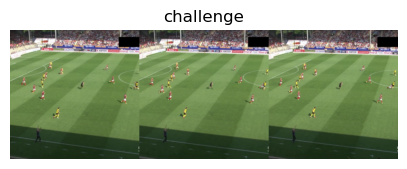

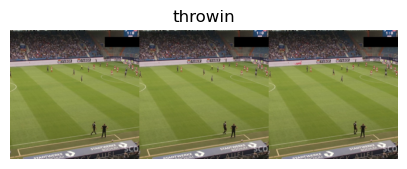

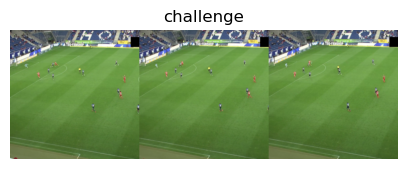

In [30]:
throwin_dls = get_action_dataloaders(instance_paths, bs=16, image_size=256, seq_len=8)
throwin_dls.show_batch()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


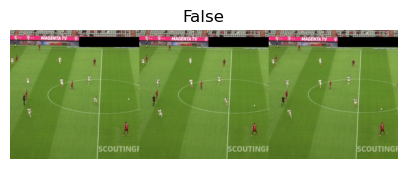

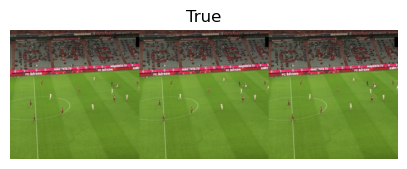

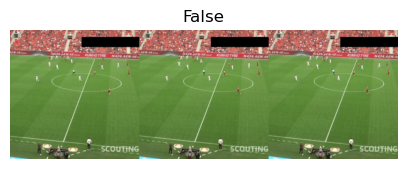

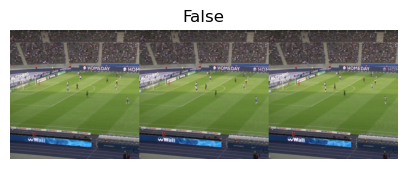

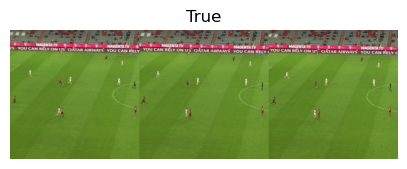

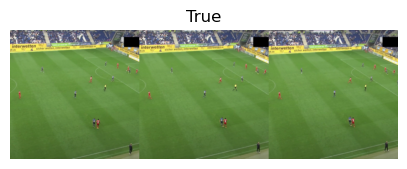

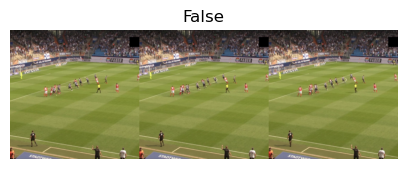

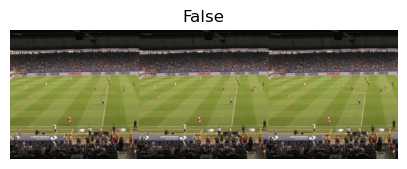

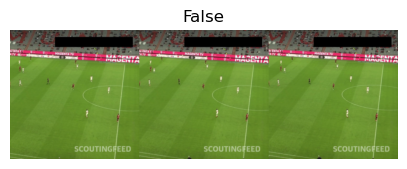

In [46]:
instance_paths = challenge_paths + throwin_paths
instance_paths += random.sample(play_paths, k=len(challenge_paths))
instance_paths += random.sample(neg_paths, k=len(challenge_paths))
challenge_dls = get_challenge_dataloaders(instance_paths, bs=16, image_size=256, seq_len=8)
challenge_dls.show_batch()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


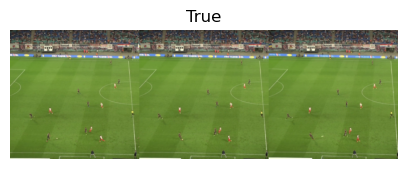

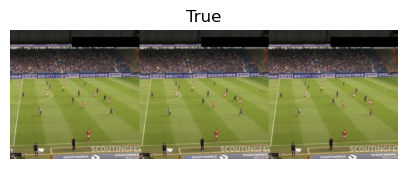

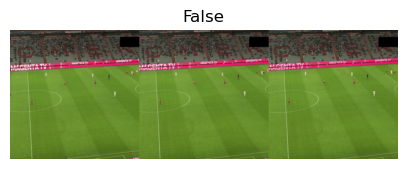

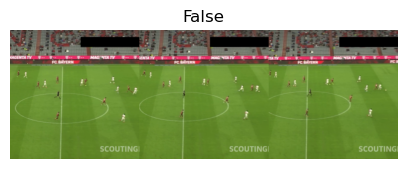

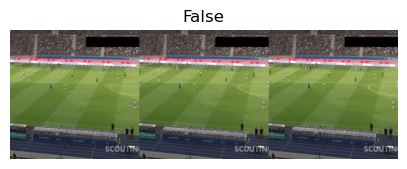

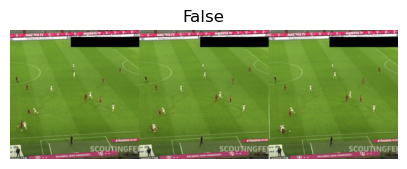

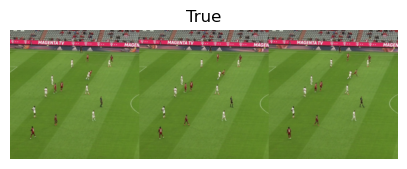

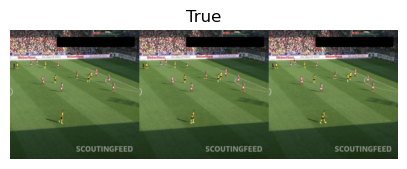

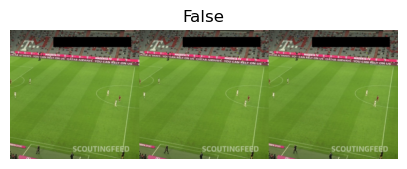

In [47]:
instance_paths = throwin_paths + challenge_paths + play_paths
instance_paths += random.sample(neg_paths, k=len(throwin_paths))
play_dls = get_play_dataloaders(instance_paths, bs=16, image_size=256, seq_len=8)
play_dls.show_batch()

In [31]:
x,y = throwin_dls.one_batch()

In [32]:
len(x)

8

In [33]:
y

TensorCategory([0, 2, 2, 3, 2, 1, 3, 1, 0, 0, 0, 0, 2, 2, 3, 2],
               device='cuda:0')

In [56]:
class RNNModel(Module):
    def __init__(self, arch=resnet34(), n_out=101, num_rnn_layers=1):
        self.encoder = TimeDistributed(nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()))
        self.rnn = nn.LSTM(512, 512, num_layers=num_rnn_layers, batch_first=True)
        self.head = LinBnDrop(num_rnn_layers*512, n_out)
    def forward(self, x):
        x = torch.stack(x, dim=1)
        x = self.encoder(x)
        bs = x.shape[0]
        _, (h, _) = self.rnn(x)
        return self.head(h.view(bs,-1))

def rnnmodel_splitter(model):
    return [params(model.encoder), params(model.rnn)+params(model.head)]

In [57]:
model = RNNModel().cuda()

In [61]:
print(f'{type(x) = },\n{len(x) = } ,\n{x[0].shape = }, \n{model(x).shape = }')

type(x) = <class '__main__.ImageTuple'>,
len(x) = 8 ,
x[0].shape = torch.Size([16, 3, 256, 256]), 
model(x).shape = torch.Size([16, 101])


In [62]:
throwin_learn = Learner(throwin_dls, model, metrics=[error_rate, F1Score(average='micro')], splitter=rnnmodel_splitter).to_fp16()
challenge_learn = Learner(challenge_dls, model, metrics=[error_rate, F1Score(average='micro')], splitter=rnnmodel_splitter).to_fp16()
play_learn = Learner(play_dls, model, metrics=[error_rate, F1Score(average='micro')], splitter=rnnmodel_splitter).to_fp16()

In [ ]:
throwin_learn.lr_find()

In [ ]:
challenge_learn.lr_find()

In [ ]:
play_learn.lr_find()

In [64]:
throwin_learn.fine_tune(1, 1e-3)

epoch,train_loss,valid_loss,error_rate,f1_score,time


KeyboardInterrupt: 

In [ ]:
print(instance_paths[0])
throwin_learn.predict(instance_paths[0])